# Imports and Settings

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import KernelDensity, BallTree
from sklearn.preprocessing import StandardScaler
from scipy.spatial import ConvexHull
from matplotlib.ticker import ScalarFormatter
import os
from colorama import Fore, Style
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import json
import plotly.express as px



# File loading


In [2]:
columns = [
    "vehicleId", 
    "lat", 
    "lng", 
    # "dateStored", 
    "velocity",
    # "odometer", 
    # "engineVoltage", 
    "dateStoredHuman", 
    # "dateOnlyStoredHuman",    
    # "timeOnly",
    "bearing",
    "orientation", 
    "seconds_diff", 
    "acceleration",
    "isProblem",
    "trip_id"
]


input_dir   = "../../DataSets/API_Responses/Vehicle_Data/"
filename    = "all_vehicle_responses.csv"

## Enable matloblib UI backend

In [3]:
# %matplotlib tk

## Save plots file

In [4]:
PLOT_FOLDER_PATH = "./Plots/"


In [5]:
def merge_csv_file(input_dir, filename, columns):
    input_file = os.path.join(input_dir, filename)

    if not os.path.exists(input_file):
        raise FileNotFoundError(f"File '{filename}' not found in directory '{input_dir}'")

    try:
        # Read the CSV while allowing missing columns
        df = pd.read_csv(input_file, usecols=lambda x: x.strip() in columns, encoding='utf-8')
    except Exception as e:
        raise ValueError(f"Error reading '{input_file}': {e}")

    return df



merged_dfs = merge_csv_file(input_dir, filename, columns)
print(merged_dfs.head())


   vehicleId        lat        lng  velocity      dateStoredHuman     bearing  \
0          1  37.510833  22.385710       0.0  2024-06-06 17:02:17  137.402376   
1          1  37.510603  22.385977       0.0  2024-06-06 17:02:20  312.778670   
2          1  37.510640  22.385927       6.0  2024-06-06 17:02:25  351.785725   
3          1  37.510750  22.385907       7.0  2024-06-06 17:02:31  307.481149   
4          1  37.510877  22.385698      26.0  2024-06-06 17:02:37  318.388767   

  orientation  seconds_diff  trip_id  acceleration  isProblem  
0   Southeast           0.0        0      0.000000          0  
1   Northwest           3.0        0      0.000000          0  
2       North           5.0        0      0.333333          0  
3   Northwest           6.0        0      0.046296          0  
4   Northwest           6.0        0      0.879630          0  


Set **Bounding Box** only for **Τρίπολη**

In [6]:
latMin = 37.49764419371479
latMax = 37.56244081620044
lngMin = 22.344992459074458
lngMax = 22.521463853839485


query_filter = 'lat >= ' +str(latMin)+' & lat <= ' + str(latMax) + ' & lng >= ' +str(lngMin)+ ' & lng <= '+str(lngMax)
veh_data_tripoli = merged_dfs.query( query_filter ).copy(True)
merged_dfs = veh_data_tripoli

# Data Overview

Text(0.5, 1.0, 'Density of problem points on spatial coordinates')

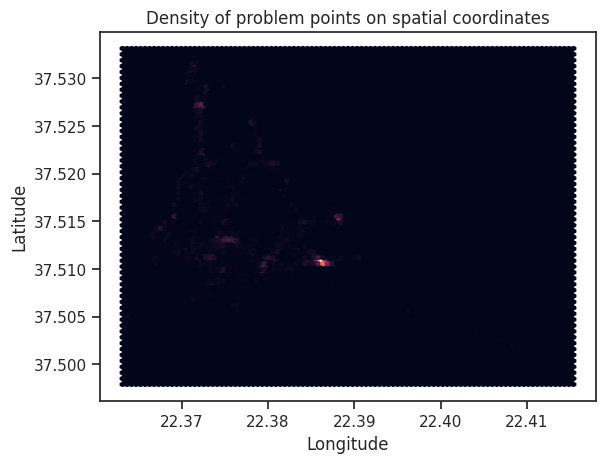

In [7]:
df = merged_dfs
df_danger = df[df['isProblem'] == 1]
# df_danger = df[df['vehicleId'] == 15]


sns.set_theme(style="ticks")
fig, ax = plt.subplots()
#sns.jointplot(x=df_danger['lng'], y=df_danger['lat'], kind="hex", color="#4CB391", ax=ax)
ax.hexbin(x=df_danger['lng'], y=df_danger['lat'])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.gca().xaxis.set_major_formatter(ScalarFormatter())
plt.gca().yaxis.set_major_formatter(ScalarFormatter())
plt.ticklabel_format(style='plain', axis='both')  # Disable scientific notation


ax.set_title('Density of problem points on spatial coordinates')

### Init DF15 (VehicleId == 15)

In [8]:
# df15 = df[df["vehicleId"] == 15]
# df15 = df15.head(500)
# df15_problem = df15[df15['isProblem'] == 1]
# plt.plot(df15.index, df15['acceleration'])
# plt.title('Acceleration vs Index')
# plt.ylabel('Acceleration')
# plt.xlabel('Index')
# plt.scatter(df15_problem.index, df15_problem['acceleration'], color='red')

# len(df15)

In [9]:
df_danger[['lng', 'lat']].describe()

,lng,lat
count,2104.000000,2104.000000
mean,22.378337,37.515161
std,0.007032,0.006116
min,22.363152,37.497893
25%,22.372463,37.510802
50%,22.376537,37.513006
75%,22.385448,37.518978
max,22.415382,37.533140


# Clustering

In [10]:
# #### MOCK DATA #####
#
# data = {
#     'lng': np.random.uniform(-180, 180, 200),
#     'lat': np.random.uniform(-90, 90, 200)
# }
# df = pd.DataFrame(data)
# df_danger = df

/tmp/ipykernel_28030/1621334586.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


Plot saved to ./Plots/


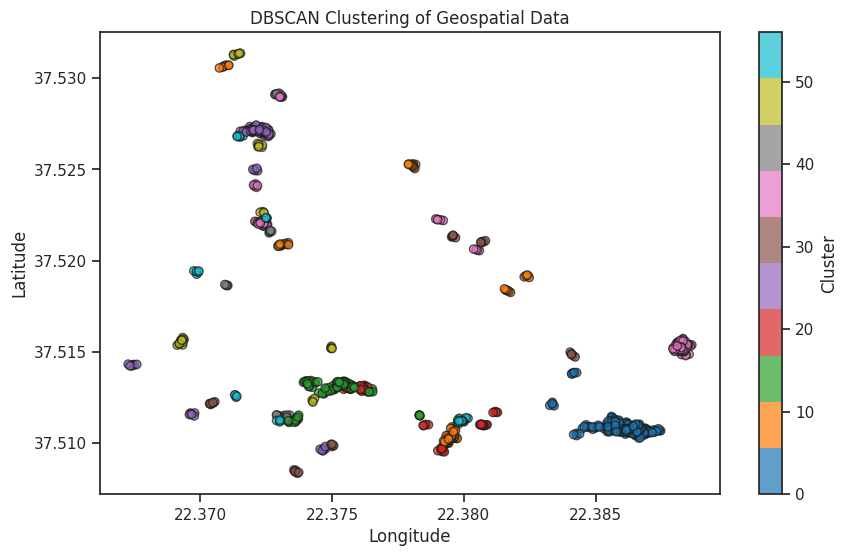

In [11]:
# Extracting the coordinates
coords = df_danger[['lng', 'lat']].values

# Standardizing the data for better clustering performance
scaler = StandardScaler()
coords_scaled = scaler.fit_transform(coords)

# Applying DBSCAN
dbscan = DBSCAN(eps=0.02, min_samples=4)  # Adjust eps as needed
clusters = dbscan.fit_predict(coords_scaled)

df_danger.loc[:, 'cluster'] = clusters  # Adding cluster labels to DataFrame


df_danger_cluster = df_danger[df_danger['cluster'] > -1]


# %matplotlib inline
# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(df_danger_cluster['lng'], df_danger_cluster['lat'], c=df_danger_cluster['cluster'], cmap='tab10', edgecolors='k', alpha=0.7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('DBSCAN Clustering of Geospatial Data')
plt.colorbar(label='Cluster')

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


In [12]:
df_danger.columns

Index(['vehicleId', 'lat', 'lng', 'velocity', 'dateStoredHuman', 'bearing',
       'orientation', 'seconds_diff', 'trip_id', 'acceleration', 'isProblem',
       'cluster'],
      dtype='object')

In [13]:
df_danger.describe()

,vehicleId,lat,lng,velocity,bearing,seconds_diff,trip_id,acceleration,isProblem,cluster
count,2104.000000,2104.000000,2104.000000,2104.00000,2104.000000,2104.000000,2104.000000,2104.000000,2104.0,2104.000000
mean,7.614068,37.515161,22.378337,14.45865,183.002406,3.532319,500.509030,-1.064275,1.0,6.814639
std,4.144250,0.006116,0.007032,14.99793,107.067732,3.075048,365.404934,1.110871,0.0,14.094810
min,1.000000,37.497893,22.363152,0.00000,0.000000,1.000000,0.000000,-14.722222,1.0,-1.000000
25%,7.000000,37.510802,22.372463,6.00000,94.893813,2.000000,184.000000,-1.111111,1.0,-1.000000
50%,7.000000,37.513006,22.376537,10.00000,188.181295,3.000000,440.000000,-0.763889,1.0,-1.000000
75%,9.000000,37.518978,22.385448,18.00000,277.609068,5.000000,736.000000,-0.555556,1.0,11.000000
max,20.000000,37.533140,22.415382,123.00000,359.405846,50.000000,1289.000000,-0.505051,1.0,56.000000


## Showing convex hulls

/tmp/ipykernel_28030/113842607.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters


Plot saved to ./Plots/


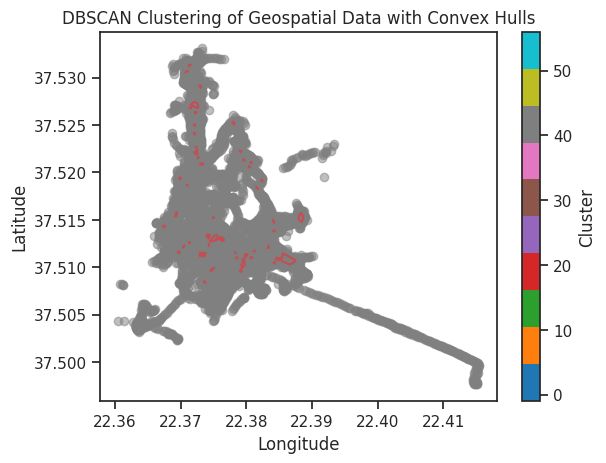

In [14]:
def plot_convex_hulls(df, clusters, normal_df_points):
    unique_clusters = set(clusters)
    colors = plt.cm.get_cmap("tab10", len(unique_clusters))  # Set of distinct colors for clusters

    fig, ax = plt.subplots()  # Create figure and axis objects

    # Plot points first for colorbar
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}', c=[colors(cluster)], s=10)

    ax.scatter(normal_df_points['lng'], normal_df_points['lat'], c='gray', alpha=0.5)

    # Plot Convex Hulls
    for cluster in unique_clusters:
        if cluster == -1:
            continue  # Skip noise points
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']].values
        if len(cluster_points) >= 3:  # Convex hull requires at least 3 points
            hull = ConvexHull(cluster_points)
            hull_points = np.append(hull.vertices, hull.vertices[0])  # Close the loop
            ax.plot(cluster_points[hull_points, 0], cluster_points[hull_points, 1], 'r-')

    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('DBSCAN Clustering of Geospatial Data with Convex Hulls')

    # Create colorbar using scatter points
    cb = fig.colorbar(plt.cm.ScalarMappable(cmap="tab10", norm=plt.Normalize(vmin=min(unique_clusters), vmax=max(unique_clusters))),
                      ax=ax, label='Cluster')

    # Save the plot
    plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
    print(f"Plot saved to {PLOT_FOLDER_PATH}")

    plt.show()

plot_convex_hulls(df_danger_cluster, clusters, df[df['isProblem'] == 0])


## Get specific **Cluster's BBOX**

In [15]:
def get_bbox_of_clusters(df, clusters):
    cluster_bboxes = {}

    # Iterate over unique clusters (excluding -1 for noise)
    unique_clusters = sorted(set(clusters) - {-1})  # Exclude noise points (-1)

    for cluster in unique_clusters:
        # Filter the points of the current cluster
        cluster_points = df[df['cluster'] == cluster][['lng', 'lat']]
        
        # Get the minimum and maximum lng and lat for the bounding box
        min_lng = cluster_points['lng'].min()
        max_lng = cluster_points['lng'].max()
        min_lat = cluster_points['lat'].min()
        max_lat = cluster_points['lat'].max()

        # Store the bounding box for the current cluster
        cluster_bboxes[cluster] = {
            'min_lng': min_lng,
            'max_lng': max_lng,
            'min_lat': min_lat,
            'max_lat': max_lat
        }

    return cluster_bboxes

cluster_bboxes = get_bbox_of_clusters(df_danger_cluster, clusters)

# Display the bounding boxes for each cluster
for cluster, bbox in cluster_bboxes.items():
    print(f"Cluster {cluster}: {bbox}")


Cluster 0: {'min_lng': 22.3853133, 'max_lng': 22.3874666, 'min_lat': 37.5102916, 'max_lat': 37.5114683}
Cluster 1: {'min_lng': 22.3841633, 'max_lng': 22.3843916, 'min_lat': 37.510425, 'max_lat': 37.5105433}
Cluster 2: {'min_lng': 22.3848866, 'max_lng': 22.3851333, 'min_lat': 37.5107683, 'max_lat': 37.5109899}
Cluster 3: {'min_lng': 22.3844933, 'max_lng': 22.3848033, 'min_lat': 37.510815, 'max_lat': 37.5110133}
Cluster 4: {'min_lng': 22.3832566, 'max_lng': 22.3834216, 'min_lat': 37.5120583, 'max_lat': 37.512245}
Cluster 5: {'min_lng': 22.3840833, 'max_lng': 22.3842783, 'min_lat': 37.5138016, 'max_lat': 37.5138783}
Cluster 6: {'min_lng': 22.37789, 'max_lng': 22.3781666, 'min_lat': 37.5250533, 'max_lat': 37.5252999}
Cluster 7: {'min_lng': 22.3729466, 'max_lng': 22.3733466, 'min_lat': 37.5208, 'max_lat': 37.5209883}
Cluster 8: {'min_lng': 22.3707233, 'max_lng': 22.3710849, 'min_lat': 37.530565, 'max_lat': 37.53072}
Cluster 9: {'min_lng': 22.3822883, 'max_lng': 22.3824783, 'min_lat': 37.519

## Plot Orientations with Convex Hulls

### Prepare the DF

In [16]:
# *Get specific columns 
_ = merged_dfs.copy()
bearings_df = _[['vehicleId', 'lat', 'lng', 'dateStoredHuman' ,'bearing', 'orientation', 'seconds_diff', 'trip_id']]
print(bearings_df)

# Filter for vehicleId == 1
df_vehicle1 = df[df['vehicleId'] == 1]

# Count occurrences of each trip_id
trip_counts = df_vehicle1['trip_id'].value_counts()

# Get the trip_id with the highest count
most_frequent_trip_id = trip_counts.idxmax()

# Display the result
print(f"The trip_id with the most rows for vehicleId 1 is: {most_frequent_trip_id}")


       vehicleId        lat        lng      dateStoredHuman     bearing  \
0              1  37.510833  22.385710  2024-06-06 17:02:17  137.402376   
1              1  37.510603  22.385977  2024-06-06 17:02:20  312.778670   
2              1  37.510640  22.385927  2024-06-06 17:02:25  351.785725   
3              1  37.510750  22.385907  2024-06-06 17:02:31  307.481149   
4              1  37.510877  22.385698  2024-06-06 17:02:37  318.388767   
...          ...        ...        ...                  ...         ...   
27477          7  37.526358  22.371557  2025-04-04 14:50:55   36.164667   
27478          7  37.526380  22.371577  2025-04-04 14:50:59  294.663042   
27479          7  37.526425  22.371453  2025-04-04 14:51:05  186.703571   
27480          7  37.526155  22.371413  2025-04-04 14:51:13  158.203780   
27481          9  37.509958  22.379578  2025-04-04 20:00:49         NaN   

      orientation  seconds_diff  trip_id  
0       Southeast           0.0        0  
1       North

### Get trip_id's rows

In [17]:
df_most_frequent_trip = df[(df['vehicleId'] == 1) & (df['trip_id'] == most_frequent_trip_id)]


print(df_most_frequent_trip.head(5))


     vehicleId        lat        lng  velocity      dateStoredHuman  \
939          1  37.510327  22.386997      15.0  2024-06-08 17:27:49   
940          1  37.510438  22.386813      15.0  2024-06-08 17:28:05   
941          1  37.510612  22.386588      31.0  2024-06-08 17:28:07   
942          1  37.510817  22.386290      45.0  2024-06-08 17:28:09   
943          1  37.510960  22.386047      34.0  2024-06-08 17:28:13   

        bearing orientation  seconds_diff  trip_id  acceleration  isProblem  
939  307.532172   Northwest         410.0       60      0.000000          0  
940  314.156549   Northwest          16.0       60      0.000000          0  
941  310.904301   Northwest           2.0       60      2.222222          0  
942  306.602094   Northwest           2.0       60      1.944444          0  
943  314.159267   Northwest           4.0       60     -0.763889          1  


## Calculate Bearing diff

In [18]:
def calculate_bearing_difference(merged_dfss):
    """
    Calculates the difference between consecutive bearing values in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): A DataFrame containing a 'bearing' column.
        
    Returns:
        pd.Series: A Series containing differences between consecutive bearings.
    """
    if 'bearing' not in df.columns or df.empty:
        return pd.Series([])
    
    df['bearing_diff'] = df['bearing'].diff().abs()
    return df

merged_dfs = calculate_bearing_difference(merged_dfs)

print(merged_dfs['bearing_diff'].head(5))


0           NaN
1    175.376294
2     39.007055
3     44.304576
4     10.907618
Name: bearing_diff, dtype: float64


## Plot std deviation

### Filter for **Convex Hull BBOXes**

In [19]:
for cluster, bbox in cluster_bboxes.items():
    print(f"Cluster {cluster}: {bbox}")


Cluster 0: {'min_lng': 22.3853133, 'max_lng': 22.3874666, 'min_lat': 37.5102916, 'max_lat': 37.5114683}
Cluster 1: {'min_lng': 22.3841633, 'max_lng': 22.3843916, 'min_lat': 37.510425, 'max_lat': 37.5105433}
Cluster 2: {'min_lng': 22.3848866, 'max_lng': 22.3851333, 'min_lat': 37.5107683, 'max_lat': 37.5109899}
Cluster 3: {'min_lng': 22.3844933, 'max_lng': 22.3848033, 'min_lat': 37.510815, 'max_lat': 37.5110133}
Cluster 4: {'min_lng': 22.3832566, 'max_lng': 22.3834216, 'min_lat': 37.5120583, 'max_lat': 37.512245}
Cluster 5: {'min_lng': 22.3840833, 'max_lng': 22.3842783, 'min_lat': 37.5138016, 'max_lat': 37.5138783}
Cluster 6: {'min_lng': 22.37789, 'max_lng': 22.3781666, 'min_lat': 37.5250533, 'max_lat': 37.5252999}
Cluster 7: {'min_lng': 22.3729466, 'max_lng': 22.3733466, 'min_lat': 37.5208, 'max_lat': 37.5209883}
Cluster 8: {'min_lng': 22.3707233, 'max_lng': 22.3710849, 'min_lat': 37.530565, 'max_lat': 37.53072}
Cluster 9: {'min_lng': 22.3822883, 'max_lng': 22.3824783, 'min_lat': 37.519

In [20]:
last_value = list(cluster_bboxes.values())[-1]

# Calculate the standard deviation of 'bearing_diff'
std_dev = merged_dfs['bearing_diff'].std()

# Define a threshold for high standard deviation
high_std_threshold = 1.5 * std_dev  # Adjust factor as needed

# Identify high standard deviation values
high_std_points = merged_dfs[merged_dfs['bearing_diff'] > high_std_threshold]

# Extract BBOX (bounding box) coordinates from last_value
min_x, min_y, max_x, max_y = last_value  # Assuming last_value holds BBOX as [min_x, min_y, max_x, max_y]




### 2️⃣ Violin Plot (Distribution)

Plot saved to ./Plots/


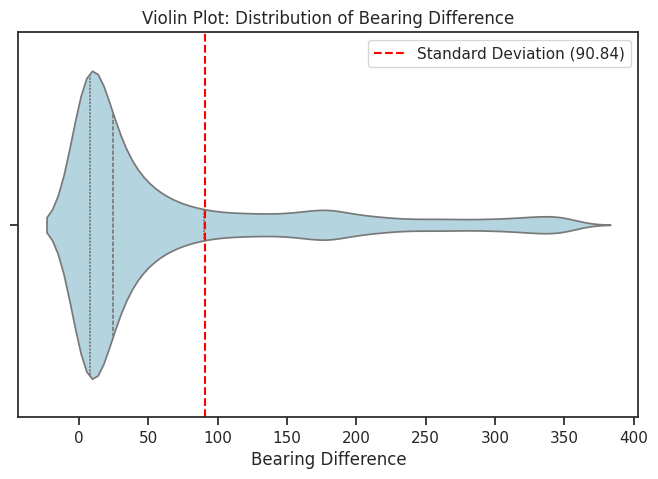

In [21]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.violinplot(x=merged_dfs['bearing_diff'], inner="quartile", color="lightblue")

# Mark the standard deviation
plt.axvline(x=std_dev, color='red', linestyle='--', label=f'Standard Deviation ({std_dev:.2f})')

plt.xlabel('Bearing Difference')
plt.title('Violin Plot: Distribution of Bearing Difference')
plt.legend()

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


### 3️⃣ Boxplot (Detect Outliers)

Plot saved to ./Plots/


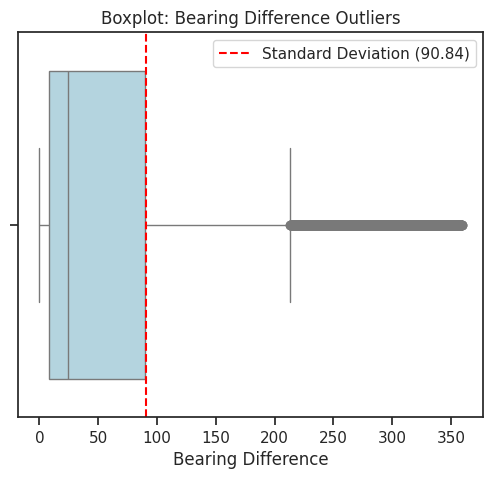

In [22]:
plt.figure(figsize=(6, 5))
sns.boxplot(x=merged_dfs['bearing_diff'], color='lightblue')

# Mark the standard deviation
plt.axvline(x=std_dev, color='red', linestyle='--', label=f'Standard Deviation ({std_dev:.2f})')

plt.xlabel('Bearing Difference')
plt.title('Boxplot: Bearing Difference Outliers')
plt.legend()

# Save the plot
plt.savefig(PLOT_FOLDER_PATH, bbox_inches='tight')
print(f"Plot saved to {PLOT_FOLDER_PATH}")

plt.show()


## Plot bearings vs seconds diff 

### ✅ Option 1: Matplotlib (simple, static plot)

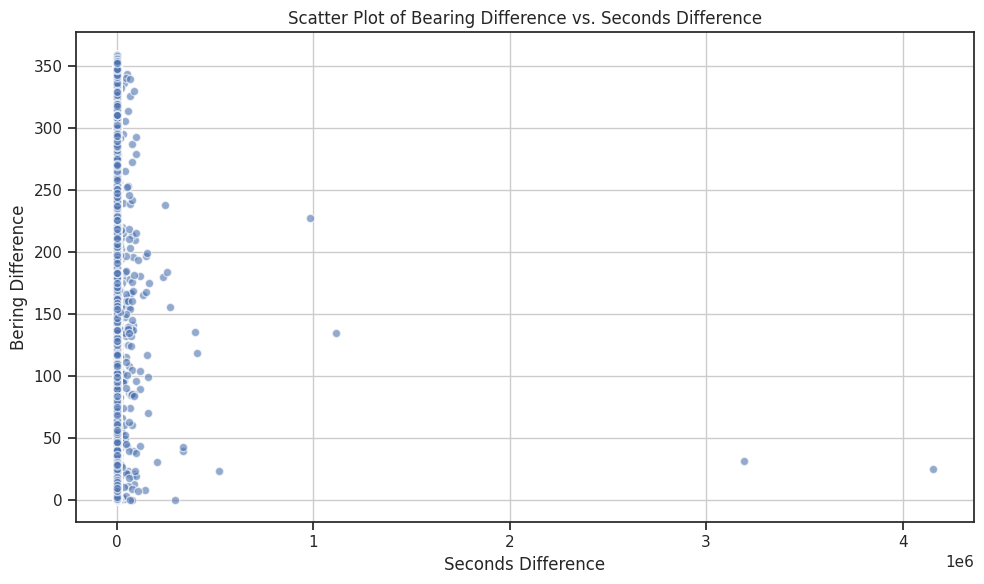

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(merged_dfs['seconds_diff'], merged_dfs['bearing_diff'], alpha=0.6, edgecolors='w')
plt.title('Scatter Plot of Bearing Difference vs. Seconds Difference')
plt.xlabel('Seconds Difference')
plt.ylabel('Bering Difference')
plt.grid(True)
plt.tight_layout()
plot_save_path = os.path.join(PLOT_FOLDER_PATH, "Scatter_bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


### ✅ Option 2: Plotly (interactive plot)

In [24]:
import plotly.express as px

fig = px.scatter(
    merged_dfs,
    x='bearing_diff',
    y='seconds_diff',
    title='Bearing Difference vs. Seconds Difference',
    labels={'bearing_diff': 'Bearing Difference', 'seconds_diff': 'Seconds Difference'},
    opacity=0.6
)

fig.show()


## Plot bearings vs 10 seconds_diff

/tmp/ipykernel_28030/3031239980.py:20: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


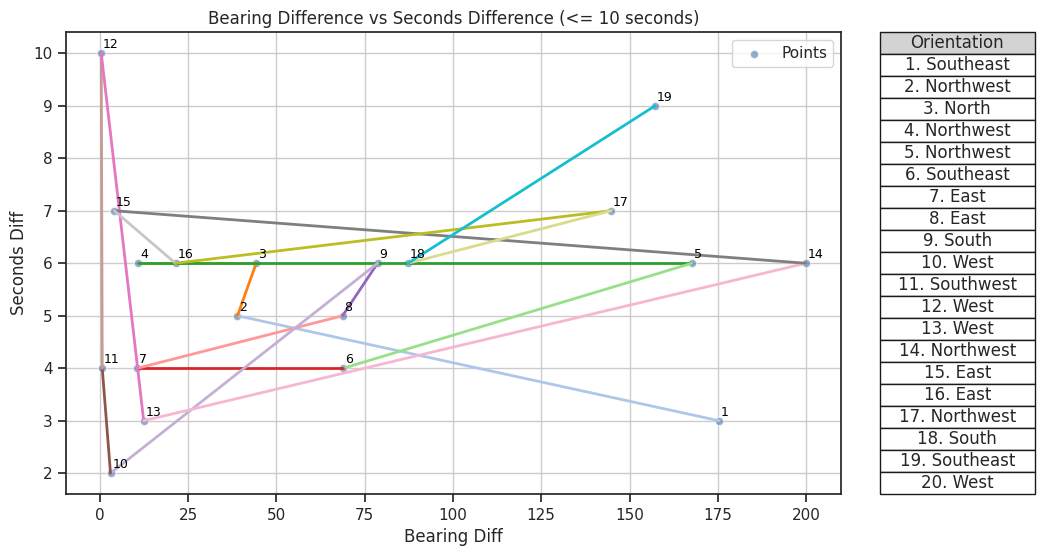

In [37]:
import matplotlib.pyplot as plt
import numpy as np

# Filter the DataFrame and take only the first 20 rows
filtered_df = merged_dfs[merged_dfs['seconds_diff'] <= 10].head(20)

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot (swapped axes)
ax.scatter(
    filtered_df['bearing_diff'],
    filtered_df['seconds_diff'],
    alpha=0.6,
    edgecolors='w',
    label='Points'
)

# Generate a list of 20 distinct colors using a colormap
colors = plt.cm.get_cmap('tab20', 20)  # Using the 'tab20' colormap

# Plot segments with changing color for each segment
for i in range(len(filtered_df) - 1):
    # Get the x and y values for the two points
    x_start = filtered_df['bearing_diff'].iloc[i]
    y_start = filtered_df['seconds_diff'].iloc[i]
    x_end = filtered_df['bearing_diff'].iloc[i + 1]
    y_end = filtered_df['seconds_diff'].iloc[i + 1]

    # Assign a unique color for each segment from the 'tab20' colormap
    color = colors(i)  # Get a different color for each segment

    # Plot each segment with its own color
    ax.plot([x_start, x_end], [y_start, y_end], color=color, lw=2)

# Add incremental labels
for i, (x, y) in enumerate(zip(filtered_df['bearing_diff'], filtered_df['seconds_diff'])):
    ax.text(x + 0.5, y + 0.1, str(i), fontsize=9, color='black')

# Prepare the orientation labels
orientation_list = [f"{i+1}. {orientation}" for i, orientation in enumerate(filtered_df['orientation'])]

# Prepare cell text for the table
cell_text = [[orientation] for orientation in orientation_list]

# Add the table on the right side of the plot (without color)
table = ax.table(cellText=cell_text,
                 colLabels=['Orientation'],
                 loc='right',
                 cellLoc='center',
                 colColours=['lightgray'],  # Keep the header background color if desired
                 bbox=[1.05, 0, 0.2, 1])  # Adjust bbox for position and size

# Labels and title
ax.set_title('Bearing Difference vs Seconds Difference (<= 10 seconds)')
ax.set_xlabel('Bearing Diff')
ax.set_ylabel('Seconds Diff')
ax.grid(True)
ax.legend()





plot_save_path = os.path.join(PLOT_FOLDER_PATH, "bearings_vs_seconds_diff.png")
plt.savefig(plot_save_path, bbox_inches='tight')
plt.show()


# Save DF to csv

In [26]:
visualize_dangers_path = "./visualize_dangers.csv"
merged_dfs.to_csv(visualize_dangers_path, index=False)
print(Fore.GREEN + f"DataFrame stored to {visualize_dangers_path}" + Style.RESET_ALL)

DataFrame stored to ./visualize_dangers.csv
